In [1]:
# preprocesssing libraries
import pandas as pd
import numpy as np

# sklearn data manipulation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    plot_confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

# catboost classifier
from catboost import CatBoostClassifier

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
location = "data/"

In [3]:
def read_data(loc, filename):
    df_in = pd.read_csv(loc + filename)
    return df_in

In [4]:
df_train = read_data(location, "Train.csv")
df_test = read_data(location, "Test.csv")
df_ss = read_data(location, "sample_submission.csv")

In [5]:
df_train.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


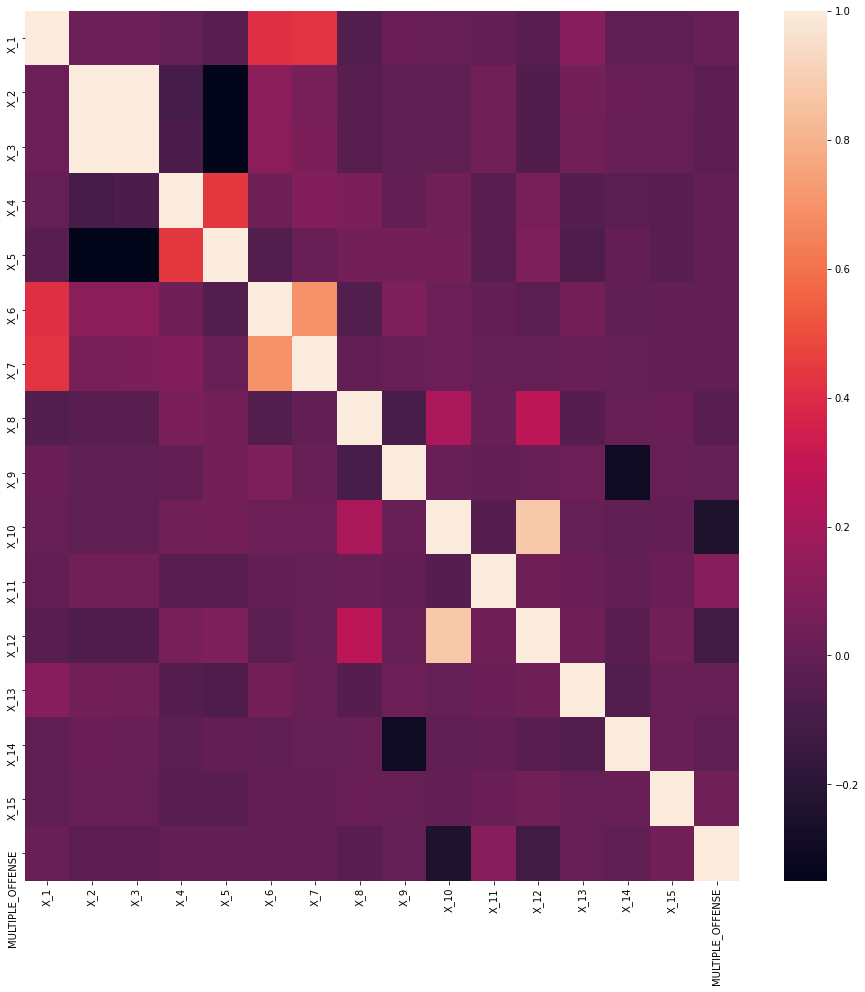

In [6]:
plt.figure(figsize=(16, 16))
sns.heatmap(df_train.corr())
plt.show()

In [7]:
## replace unknown data
def fill_unknown(df, col):
    df[col] = df[col].fillna(-1)
    df[col] = df[col].replace([np.inf, -np.inf], -1)
    df[col] = df[col].astype(int)
    return df

In [8]:
## parse date columns
def todate(df,col):
    df[col] = pd.to_datetime(df[col])
    return df

In [9]:
df_train = fill_unknown(df_train, "X_12")
df_test = fill_unknown(df_test, "X_12")
df_train = todate(df_train, "DATE")
df_test = todate(df_test, "DATE")


In [10]:
df_train["MULTIPLE_OFFENSE"].value_counts()

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

In [11]:
X = df_train.drop(["INCIDENT_ID", "MULTIPLE_OFFENSE"], axis=1)
y = df_train[["MULTIPLE_OFFENSE"]]

test = df_test.drop(["INCIDENT_ID"], axis=1)
df_sub = df_test[["INCIDENT_ID"]]

# 	x_train = x
# 	y_train = y
# 	x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=22

In [12]:
## Adding features
def feature_engg(df):
    df["srday"] = df["DATE"].dt.day
    df["srmon"] = df["DATE"].dt.month

    ## binning days
    df.loc[df["srday"] <= 10, "day_buc"] = 1
    df.loc[(df["srday"] > 10) & (df["srday"] <= 20), "day_buc"] = 2
    df.loc[df["srday"] > 20, "day_buc"] = 3

    ## binning months into quarter
    df.loc[df["srmon"] <= 3, "quarter"] = 1
    df.loc[(df["srmon"] > 3) & (df["srmon"] <= 6), "quarter"] = 2
    df.loc[(df["srmon"] > 6) & (df["srmon"] <= 9), "quarter"] = 3
    df.loc[df["srmon"] > 9, "quarter"] = 4
    
    df['day_buc'] = df['day_buc'].astype(int)
    df['quarter'] = df['quarter'].astype(int)

    ## clubbing of low imp features in model
    #     df['combo'] = df['X_3'].astype(str) + df['X_6'].astype(str)
    #     df['combo'] = df['combo'].astype(int)

    ## drop correlated and low imp features
#     df.drop(
#         ["DATE", "X_1", "X_3", "X_6", "X_8", "srmon"],
#         axis=1,
#         inplace=True,
#     )
    return df

In [13]:
X = feature_engg(X)
test = feature_engg(test)

X.head()

,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,srday,srmon,day_buc,quarter
0,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1,92,29,36,4,7,1,3
1,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1,103,142,34,18,7,2,3
2,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1,110,93,34,15,3,2,1
3,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1,72,29,34,13,2,2,1
4,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0,112,29,43,13,4,2,2


In [14]:
X.dtypes

DATE       datetime64[ns]
X_1                 int64
X_2                 int64
X_3                 int64
X_4                 int64
X_5                 int64
X_6                 int64
X_7                 int64
X_8                 int64
X_9                 int64
X_10                int64
X_11                int64
X_12                int64
X_13                int64
X_14                int64
X_15                int64
srday               int64
srmon               int64
day_buc             int64
quarter             int64
dtype: object

In [15]:
X.shape

(23856, 20)

In [16]:
cat_features_ids = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 17, 18, 19]

In [17]:
def display_importances(feature_importance_df_):
    cols = (
        feature_importance_df_[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:40]
        .index
    )
    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)
    ]
    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title("LightGBM Features")
    plt.tight_layout()

Fold  1
Train: 0=854, 1=18230, Test: 0=214, 1=4558
0:	test: 0.5346613	best: 0.5346613 (0)	total: 68ms	remaining: 22m 39s
2000:	test: 1.0000000	best: 1.0000000 (69)	total: 18.2s	remaining: 2m 43s
4000:	test: 1.0000000	best: 1.0000000 (69)	total: 36.1s	remaining: 2m 24s
6000:	test: 1.0000000	best: 1.0000000 (69)	total: 54.1s	remaining: 2m 6s
8000:	test: 1.0000000	best: 1.0000000 (69)	total: 1m 12s	remaining: 1m 49s
10000:	test: 1.0000000	best: 1.0000000 (69)	total: 1m 31s	remaining: 1m 31s
12000:	test: 1.0000000	best: 1.0000000 (69)	total: 1m 49s	remaining: 1m 12s
14000:	test: 1.0000000	best: 1.0000000 (69)	total: 2m 7s	remaining: 54.7s
16000:	test: 1.0000000	best: 1.0000000 (69)	total: 2m 24s	remaining: 36.2s
18000:	test: 1.0000000	best: 1.0000000 (69)	total: 2m 42s	remaining: 18s
19999:	test: 1.0000000	best: 1.0000000 (69)	total: 3m	remaining: 0us

bestTest = 1
bestIteration = 69

Shrink model to first 70 iterations.
train matrix


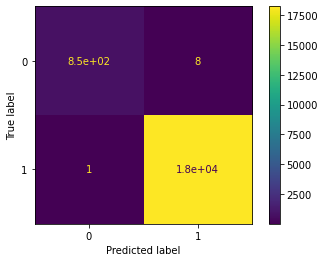

test matrix


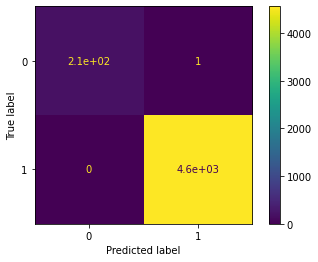

AUC : 0.500000


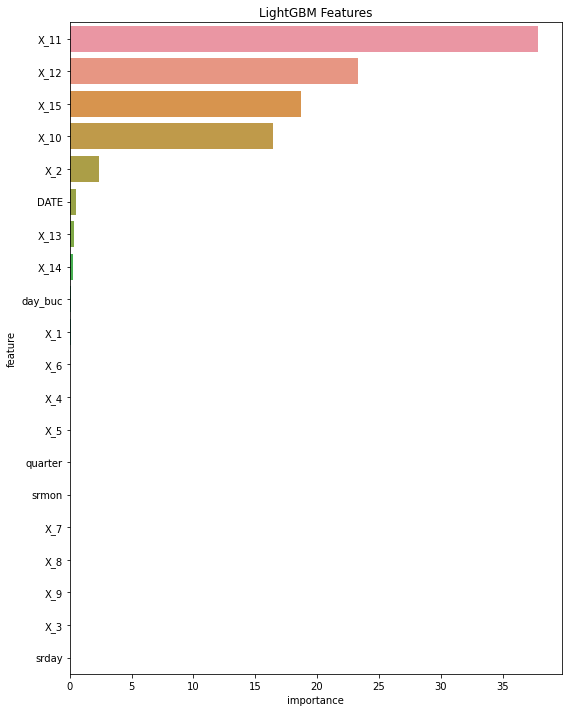

Fold  2
Train: 0=854, 1=18231, Test: 0=214, 1=4557
0:	test: 0.5135239	best: 0.5135239 (0)	total: 6.72ms	remaining: 2m 14s
2000:	test: 1.0000000	best: 1.0000000 (43)	total: 19s	remaining: 2m 50s
4000:	test: 1.0000000	best: 1.0000000 (43)	total: 37.9s	remaining: 2m 31s
6000:	test: 1.0000000	best: 1.0000000 (43)	total: 57.9s	remaining: 2m 14s
8000:	test: 1.0000000	best: 1.0000000 (43)	total: 1m 18s	remaining: 1m 57s
10000:	test: 1.0000000	best: 1.0000000 (43)	total: 1m 37s	remaining: 1m 37s
12000:	test: 1.0000000	best: 1.0000000 (43)	total: 1m 57s	remaining: 1m 18s
14000:	test: 1.0000000	best: 1.0000000 (43)	total: 2m 16s	remaining: 58.4s
16000:	test: 1.0000000	best: 1.0000000 (43)	total: 2m 35s	remaining: 39s
18000:	test: 1.0000000	best: 1.0000000 (43)	total: 2m 55s	remaining: 19.4s
19999:	test: 1.0000000	best: 1.0000000 (43)	total: 3m 14s	remaining: 0us

bestTest = 1
bestIteration = 43

Shrink model to first 44 iterations.
train matrix


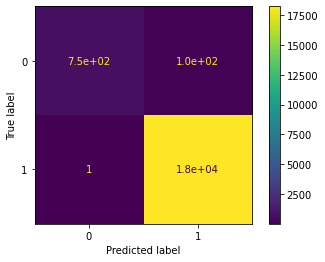

test matrix


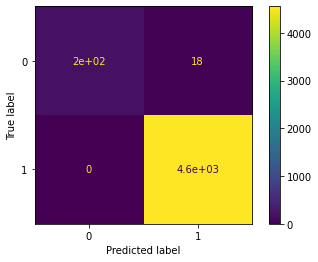

AUC : 0.500000


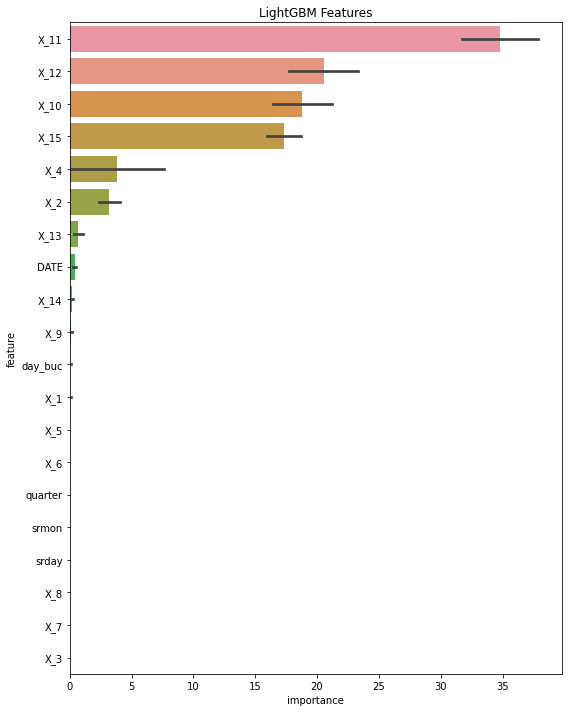

Fold  3
Train: 0=854, 1=18231, Test: 0=214, 1=4557
0:	test: 0.5458825	best: 0.5458825 (0)	total: 11.5ms	remaining: 3m 49s
2000:	test: 1.0000000	best: 1.0000000 (116)	total: 17.6s	remaining: 2m 38s
4000:	test: 1.0000000	best: 1.0000000 (116)	total: 34.9s	remaining: 2m 19s
6000:	test: 1.0000000	best: 1.0000000 (116)	total: 51.2s	remaining: 1m 59s
8000:	test: 1.0000000	best: 1.0000000 (116)	total: 1m 7s	remaining: 1m 40s
10000:	test: 1.0000000	best: 1.0000000 (116)	total: 1m 22s	remaining: 1m 22s
12000:	test: 1.0000000	best: 1.0000000 (116)	total: 1m 40s	remaining: 1m 7s
14000:	test: 1.0000000	best: 1.0000000 (116)	total: 1m 59s	remaining: 51.3s
16000:	test: 1.0000000	best: 1.0000000 (116)	total: 2m 20s	remaining: 35s
18000:	test: 1.0000000	best: 1.0000000 (116)	total: 2m 39s	remaining: 17.7s
19999:	test: 1.0000000	best: 1.0000000 (116)	total: 2m 57s	remaining: 0us

bestTest = 1
bestIteration = 116

Shrink model to first 117 iterations.
train matrix


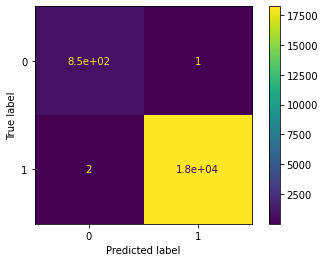

test matrix


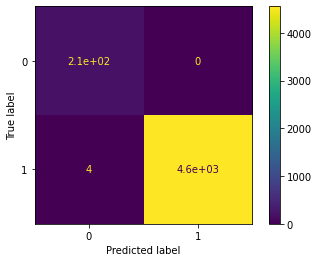

AUC : 0.500000


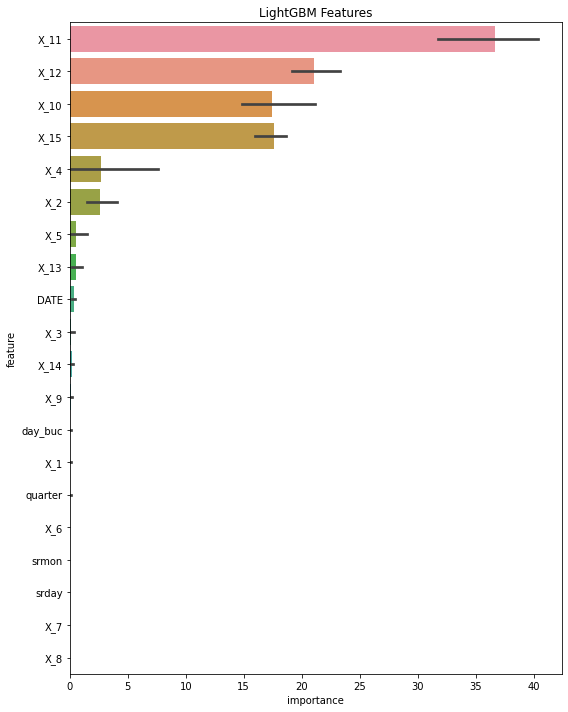

Fold  4
Train: 0=855, 1=18230, Test: 0=213, 1=4558
0:	test: 0.4937612	best: 0.4937612 (0)	total: 6.04ms	remaining: 2m
2000:	test: 0.9999681	best: 0.9999701 (160)	total: 17.2s	remaining: 2m 35s
4000:	test: 0.9999691	best: 0.9999701 (160)	total: 35s	remaining: 2m 20s
6000:	test: 0.9999701	best: 0.9999701 (160)	total: 52.1s	remaining: 2m 1s
8000:	test: 0.9999701	best: 0.9999701 (160)	total: 1m 7s	remaining: 1m 41s
10000:	test: 0.9999701	best: 0.9999701 (160)	total: 1m 23s	remaining: 1m 23s
12000:	test: 0.9999670	best: 0.9999701 (160)	total: 1m 40s	remaining: 1m 7s
14000:	test: 0.9999835	best: 0.9999835 (13228)	total: 1m 58s	remaining: 50.8s
16000:	test: 0.9999835	best: 0.9999835 (13228)	total: 2m 16s	remaining: 34.2s
18000:	test: 0.9999835	best: 0.9999835 (13228)	total: 2m 35s	remaining: 17.2s
19999:	test: 0.9999835	best: 0.9999835 (13228)	total: 2m 52s	remaining: 0us

bestTest = 0.9999835197
bestIteration = 13228

Shrink model to first 13229 iterations.
train matrix


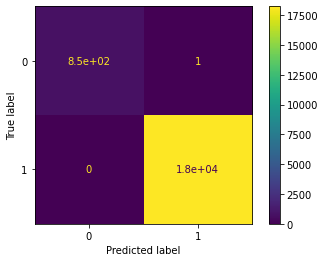

test matrix


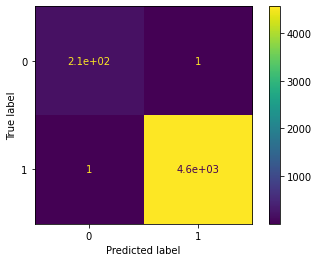

AUC : 0.500000


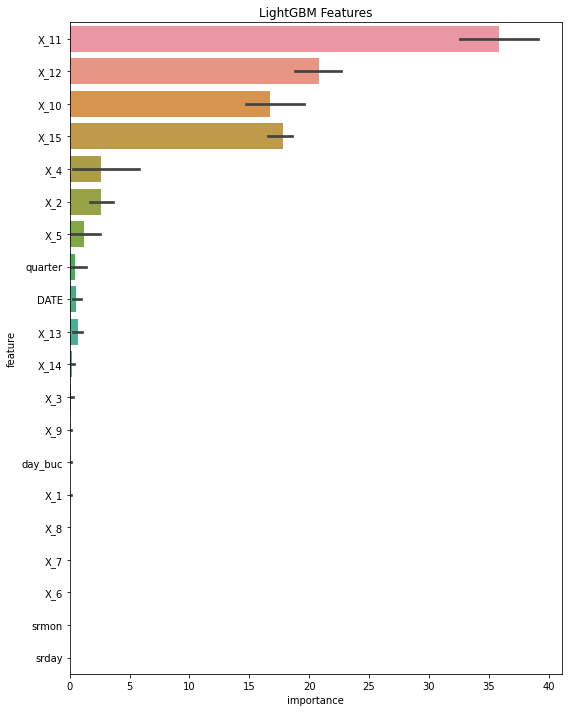

Fold  5
Train: 0=855, 1=18230, Test: 0=213, 1=4558
0:	test: 0.5126286	best: 0.5126286 (0)	total: 6.34ms	remaining: 2m 6s
2000:	test: 1.0000000	best: 1.0000000 (112)	total: 19.9s	remaining: 2m 58s
4000:	test: 1.0000000	best: 1.0000000 (112)	total: 39.9s	remaining: 2m 39s
6000:	test: 1.0000000	best: 1.0000000 (112)	total: 1m	remaining: 2m 21s
8000:	test: 1.0000000	best: 1.0000000 (112)	total: 1m 20s	remaining: 2m 1s
10000:	test: 1.0000000	best: 1.0000000 (112)	total: 1m 41s	remaining: 1m 41s
12000:	test: 1.0000000	best: 1.0000000 (112)	total: 2m 3s	remaining: 1m 22s
14000:	test: 1.0000000	best: 1.0000000 (112)	total: 2m 24s	remaining: 1m 2s
16000:	test: 1.0000000	best: 1.0000000 (112)	total: 2m 44s	remaining: 41.1s
18000:	test: 1.0000000	best: 1.0000000 (112)	total: 3m 6s	remaining: 20.7s
19999:	test: 1.0000000	best: 1.0000000 (112)	total: 3m 27s	remaining: 0us

bestTest = 1
bestIteration = 112

Shrink model to first 113 iterations.
train matrix


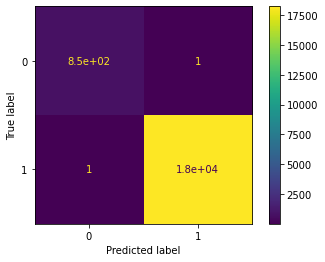

test matrix


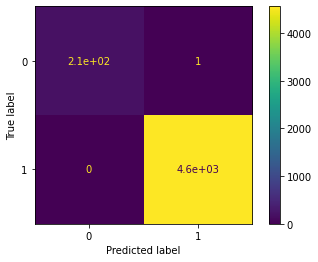

AUC : 0.500000


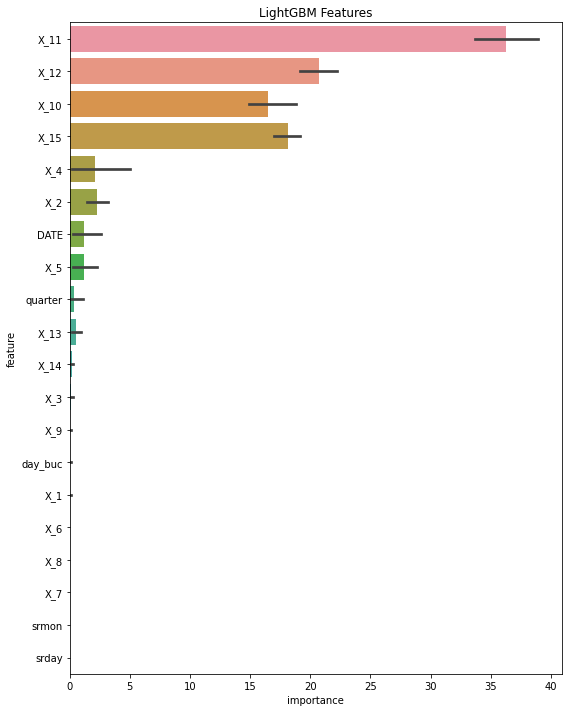

In [18]:
feature_importance_df = pd.DataFrame()
oof_preds = np.zeros(X.shape[0])
i = 0
num_folds = 5

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)


for n_fold, (train_ix, test_ix) in enumerate(kfold.split(X, y)):
    # select rows
    train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

    # summarize train and test composition
    train_0, train_1 = (
        len(train_y[train_y["MULTIPLE_OFFENSE"] == 0]),
        len(train_y[train_y["MULTIPLE_OFFENSE"] == 1]),
    )
    test_0, test_1 = (
        len(test_y[test_y["MULTIPLE_OFFENSE"] == 0]),
        len(test_y[test_y["MULTIPLE_OFFENSE"] == 1]),
    )
    print("===========================")
    print("Fold %2d" % (n_fold + 1))
    print("===========================")
    print("Train: 0=%d, 1=%d, Test: 0=%d, 1=%d" % (train_0, train_1, test_0, test_1))
    
    ## Lightgbm classifier
    clf = CatBoostClassifier(n_estimators=20000, learning_rate=0.02, eval_metric="AUC")

    clf.fit(
        train_X,
        train_y,
        eval_set=(test_X, test_y),
        verbose=2000,
        cat_features=cat_features_ids
    )
    pred_split_probs = clf.predict_proba(test_X)[
        :, 1
    ]
    

    ##calculate precisin per each split
    precision, recall, thresholds = precision_recall_curve(test_y, pred_split_probs)

    print("train matrix")
    disp = plot_confusion_matrix(clf, train_X, train_y)
    plt.show()
    print("test matrix")
    disp = plot_confusion_matrix(clf, test_X, test_y)
    plt.show()

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_X.columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_importance_df], axis=0
    )
    print(
        "AUC : %.6f" % (roc_auc_score(test_y, oof_preds[test_ix]))
    )

    display_importances(feature_importance_df)
    plt.show()

    if i == 0:
        prec = precision
        rec = recall
        thres = thresholds
    else:
        prec = np.append(prec, precision)
        rec = np.append(rec, recall)
        thres = np.append(thres, thresholds)

    ## predict actual values
    pred_probs = clf.predict_proba(test)[:, 1]
    i = i + 1
    col_name = "MULTIPLE_OFFENSE" + str(i)
    df_sub[col_name] = pred_probs

In [19]:
def get_metric_and_best_threshold_from_roc_curve(
    tpr, fpr, thresholds, num_pos_class, num_neg_class
):
    tp = tpr * num_pos_class
    tn = (1 - fpr) * num_neg_class
    acc = (tp + tn) / (num_pos_class + num_neg_class)

    best_threshold = thresholds[np.argmax(acc)]
    return np.amax(acc), best_threshold


def get_metric_and_best_threshold_from_pr_curve(
    precision, recall, thresholds, num_pos_class, num_neg_class
):
    tp = recall * num_pos_class
    fp = (tp / precision) - tp
    tn = num_neg_class - fp
    acc = (tp + tn) / (num_pos_class + num_neg_class)

    best_threshold = thresholds[np.argmax(acc)]
    return np.amax(acc), best_threshold

In [20]:
max_recall, best_thres = get_metric_and_best_threshold_from_pr_curve(
    prec, rec, thres, 1, 1
)
print("Max Recall: ", max_recall)
print("Best Threshold: ", best_thres)

Max Recall:  1.0
Best Threshold:  0.5265513118641452


In [21]:
## Get average of predict proba and apply best threshold for binary classification
df_sub["MULTIPLE_OFFENSE_sum"] = (
    df_sub["MULTIPLE_OFFENSE1"]
    + df_sub["MULTIPLE_OFFENSE2"]
    + df_sub["MULTIPLE_OFFENSE3"]
    + df_sub["MULTIPLE_OFFENSE4"]
    + df_sub["MULTIPLE_OFFENSE5"]
)

df_sub["MULTIPLE_OFFENSE"] = df_sub["MULTIPLE_OFFENSE_sum"].apply(
    lambda x: 1 if x / 5 >= best_thres else 0
)

In [22]:
df_finalsub = df_sub[["INCIDENT_ID", "MULTIPLE_OFFENSE"]]
df_finalsub["MULTIPLE_OFFENSE"].value_counts()

1    15186
0      717
Name: MULTIPLE_OFFENSE, dtype: int64

In [23]:
df_finalsub.to_csv("highest_submission.csv", index=False)